In [1]:
from explore_import import  *
from collections import defaultdict

In [29]:
fig_save="./oui_discovery_gwalk_subfigures/plot-0-fdp-op-subgroupes/"

In [32]:
#reference http://localhost:1327/notebooks/plot-0-fdp.ipynb
#load files from Francis
#fdp_op=pd.read_csv("./../all_subsets_stats.csv")

#reference analysis_on_groupwalk/Ionbot_FDP-main/workflow/scripts/plot_openprot_subset_fdp.py
fdp_working_dir="./ionbot_results_fdp/peptide_level/"
STATS_CSV = ""

SEARCH_TYPE = ["ClosedSearch","OpenSearch"]
GROUP_TYPE = ["PTM","MassShift"]
PXD = ["PXD002057","PXD005833","PXD014258"]
DATABASE=["open"]
APPROACH = ["classic","groupwise","groupwalk"]
FDP_SUF="_fdp.csv"
groups = [["common", "unique_canonical"], ["unique_noncanonical"]]

In [33]:
run_results = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(
                    lambda: defaultdict(pd.DataFrame)
                )
            )
        )
    )
)

# Extract data

keys_deapth=[]
for search in SEARCH_TYPE:
    for group in GROUP_TYPE:
        for pxd in PXD:
            for database in DATABASE:
                subsets= database=="open"
                for approach in APPROACH:
                    files=glob.glob(f"{fdp_working_dir}{search}_{group}/{pxd}-{database}/{approach}/{'subsets/' if subsets else '' }*{FDP_SUF}")
                    if subsets:
                        for subset in groups:
                            files_subset=[file for file in files if any(sub in file for sub in subset)]
                            print(search,group,pxd,database,approach,subset)
                            print(files_subset)
                            df=pd.concat([pd.read_csv(file, sep=",") for file in files_subset])
                            df.reset_index(drop=True,inplace=True)
                            df[["q_value", "lower_bound_fdp", "paired_fdp"]] *= 100
                            df = df[df["q_value"] <= 10]
                            df["search_type"]=search
                            df['group_type']=group
                            df['pxd']=pxd
                            df['database']=database
                            df['approach']=approach
                            df['subset']="+".join(subset)
                            run_results[search][group][pxd][database][approach]["+".join(subset)] = df
                            keys_deapth.append([search,group,pxd,database,approach,"+".join(subset)])
keys_deapth=pd.DataFrame(keys_deapth,columns=['search_type', 'group_type','pxd','database','approach','subset'])                            

ClosedSearch PTM PXD002057 open classic ['common', 'unique_canonical']
['./ionbot_results_fdp/peptide_level/ClosedSearch_PTM/PXD002057-open/classic/subsets/unique_canonical_130327_o2_06_hu_P3_2hr_fdp.csv', './ionbot_results_fdp/peptide_level/ClosedSearch_PTM/PXD002057-open/classic/subsets/unique_canonical_130327_o2_05_hu_C3_2hr_fdp.csv', './ionbot_results_fdp/peptide_level/ClosedSearch_PTM/PXD002057-open/classic/subsets/common_130327_o2_03_hu_C2_2hr_fdp.csv', './ionbot_results_fdp/peptide_level/ClosedSearch_PTM/PXD002057-open/classic/subsets/unique_canonical_130327_o2_04_hu_P2_2hr_fdp.csv', './ionbot_results_fdp/peptide_level/ClosedSearch_PTM/PXD002057-open/classic/subsets/common_130327_o2_02_hu_P1_2hr_fdp.csv', './ionbot_results_fdp/peptide_level/ClosedSearch_PTM/PXD002057-open/classic/subsets/common_130327_o2_01_hu_C1_2hr_fdp.csv', './ionbot_results_fdp/peptide_level/ClosedSearch_PTM/PXD002057-open/classic/subsets/unique_canonical_130327_o2_02_hu_P1_2hr_fdp.csv', './ionbot_results_fd

In [34]:
#reference utils.py

# Size of the rolling window used in average_runs() and get_std_bound()

def average_runs(df,ROLLING_WINDOW = 250):
    """Use a rolling window to average the FDP metrics across all runs of the
    given dataset"""

    # Make sure df is sorted
    df = df.sort_values("q_value").reset_index()

    cols = ["combined_fdp", "lower_bound_fdp", "paired_fdp", "q_value"]
    averaged_df = df[cols].rolling(window=ROLLING_WINDOW).mean()
    #averaged_df["peptide"] = df.peptide
    #@ delet empty rows
    averaged_df=averaged_df.loc[averaged_df.isna().all(axis=1)==False,].reset_index()
    return averaged_df
def get_std_bound(df,ROLLING_WINDOW = 250):
    """Use a rolling window to calculate the standard deviation of the FDP metrics
    across all runs of the given dataset"""

    # Make sure df is sorted
    df = df.sort_values("q_value").reset_index()

    # Get std
    cols = ["combined_fdp", "lower_bound_fdp", "paired_fdp", "q_value"]
    std_df=df[cols].rolling(window=ROLLING_WINDOW).std()
    std_df=std_df.loc[std_df.isna().all(axis=1)==False,].reset_index()
    return std_df

In [35]:
#avaraged with rolling window

keys_sel=keys_deapth.copy(deep=True)#[(keys_deapth.approach=="classic")&(keys_deapth.subset=="common+unique_canonical")]
keys_sel["fdr_1_upper_bound_av"]="NA"
keys_sel["fdr_1_lower_bound_av"]="NA"
for i,row in keys_sel.iterrows():
    search,group,pxd,database,approach,subset = row.values[:-2]
    df=run_results[search][group][pxd][database][approach][subset]
    ROLLING_WINDOW = 250 if subset!="unique_noncanonical" else 10
    averaged_df=average_runs(df,ROLLING_WINDOW) #sorted
    std_df = get_std_bound(df,ROLLING_WINDOW)
    stats_df=averaged_df.merge(std_df, on="index", suffixes=("_av","_std"))
    idx = stats_df.index[stats_df["q_value_av"] < 1]
    val=stats_df['paired_fdp_av'][idx[-1]]
    keys_sel.loc[i,"fdr_1_upper_bound_av"]=val#round(val,1)
    val=stats_df['lower_bound_fdp_av'][idx[-1]]
    keys_sel.loc[i,"fdr_1_lower_bound_av"]=val

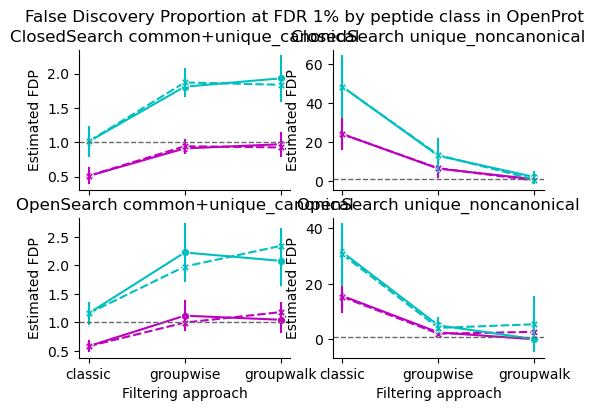

In [48]:
# reference http://localhost:1327/notebooks/plot-0-fdp.ipynb

data=keys_sel.copy(deep=True)
data=data.melt(id_vars=['subset', 'search_type', 'group_type', 'approach'], value_vars=['fdr_1_lower_bound_av', 'fdr_1_upper_bound_av'])
fig, axes = plt.subplots(2,2,sharex=True,figsize=(6,4))
fig.suptitle("False Discovery Proportion at FDR 1% by peptide class in OpenProt")
palette={"fdr_1_lower_bound_av":"m","fdr_1_upper_bound_av":"c"}
for i,search_type in enumerate(data.search_type.unique()):
    for j,subset in enumerate(["common+unique_canonical","unique_noncanonical"]):
        group=data.groupby(["search_type","subset"]).get_group((search_type,subset))
        sns.lineplot(ax=axes[i,j],data=group, x="approach", y="value", hue="variable", style="group_type", 
                     markers=True,err_style="bars", errorbar=("se", 2), palette=palette, legend=False)#True if j==1 and i==0 else False)
        sns.despine()
        #if j!=2: axes[i,j].set_ylim(0,10)
        axes[i,j].axhline(y=1, color='dimgrey', linestyle='--',linewidth=1)
        axes[i,j].set_title(f"{search_type} {subset}")
        axes[i,j].set_ylabel("Estimated FDP")
        axes[i,j].set_xlabel("Filtering approach")
plt.savefig(f"{fig_save}fdp_bypepcl_lineplot.svg",format='svg', bbox_inches = 'tight')

In [39]:
keys_sel[(keys_sel.approach=="classic")&(keys_sel.subset=="common+unique_canonical")].fdr_1_upper_bound_av.max()

np.float64(1.264566681800905)

In [40]:
keys_sel[(keys_sel.approach=="classic")&(keys_sel.subset=="unique_noncanonical")].fdr_1_upper_bound_av.max()

np.float64(59.90255230710083)

In [45]:
keys_sel[(keys_sel.approach=="groupwise")&(keys_sel.subset=="unique_noncanonical")&(keys_sel.group_type=="PTM")]["fdr_1_upper_bound_av"].mean()

np.float64(9.118885803964154)

In [44]:
keys_sel[(keys_sel.approach=="groupwise")&(keys_sel.subset=="unique_noncanonical")&(keys_sel.group_type=="PTM")].groupby("search_type")["fdr_1_upper_bound_av"].max()

search_type
ClosedSearch        20.0
OpenSearch      7.593664
Name: fdr_1_upper_bound_av, dtype: object

In [46]:
keys_sel[(keys_sel.approach=="groupwalk")&(keys_sel.subset=="unique_noncanonical")&(keys_sel.group_type=="PTM")].groupby("search_type")["fdr_1_upper_bound_av"].max()

search_type
ClosedSearch    4.761905
OpenSearch       0.37037
Name: fdr_1_upper_bound_av, dtype: object